## 1. **Configuração de Ambiente e Reprodução**

In [1]:
# =================================================================
# IMPORTS E CONFIGURAÇÕES
# =================================================================
import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
# TFMOT (TensorFlow Model Optimization) é essencial para QAT
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.quantization.keras import quantize_model, quantize_scope

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from typing import Optional, Tuple, Dict, Any




2025-12-02 15:12:58.731703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 15:12:58.786802: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:

# --- Configuração de Reprodução ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# --- Configuração de GPU/Dispositivo ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
        print(f"🔥 Usando estratégia de distribuição com {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
        strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.get_strategy()
    print("⚠️ Nenhuma GPU detectada. Usando a estratégia padrão.")

strategy_scope_used = len(gpus) > 0

# --- Paths e Configurações Globais ---
# ATENÇÃO: Ajuste este PATH_ROOT para o seu ambiente
ROOT = Path("/home/ampliar/cancer-classify-citology/citology-pipeline-Train") 
DATA_DIR = ROOT / 'Dataset' / 'pre-processado'
MODELS_DIR = ROOT / 'models'
METRICS_DIR = ROOT / 'metrics' # NOVA PASTA PARA HISTÓRICOS E GRÁFICOS
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

TRAIN_CSV = DATA_DIR / 'train_data.csv'
VAL_CSV = DATA_DIR / 'val_data.csv'
TEST_CSV = DATA_DIR / 'test_data.csv'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
IMAGE_ROOT = DATA_DIR 

# Hyperparâmetros de Treinamento
EPOCHS_BASELINE = 10
LR_BASELINE = 1e-4

EPOCHS_ROBUST = 20
LR_ROBUST_CANDIDATES = [1e-3, 1e-4, 5e-5] # Candidatos do seu código original
LR_FINETUNE = 1e-5 # LR para Fine-Tuning FP32 (Etapa 3)
EPOCHS_FINETUNE = 10

# Hyperparâmetros QAT
LR_QAT = 1e-5 # LR para Fine-Tuning QAT (Etapa 4)
EPOCHS_QAT = 10 
QAT_CHECKPOINT = str(MODELS_DIR / 'qat_checkpoint.keras')
QAT_TFLITE_PATH = MODELS_DIR / 'qat_model.tflite'
CHECKPOINT_BASELINE = str(MODELS_DIR / 'baseline_checkpoint.keras')
CHECKPOINT_ROBUST = str(MODELS_DIR / 'robust_best.keras') # Será o ponto de partida do FT/QAT
CHECKPOINT_FINETUNE = str(MODELS_DIR / 'final_finetuned_checkpoint.keras')



⚠️ Nenhuma GPU detectada. Usando a estratégia padrão.


2025-12-02 15:13:05.358475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-02 15:13:05.359940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: /home/ampliar/miniconda3/envs/qat_cancer_env/lib/python3.9/site-packages/tensorflow/python/../../../../libcublas.so.11: undefined symbol: cublasLt_for_cublas_HSS, version libcublasLt.so.11; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2025-12-02 15:13:05.385244: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 2. **Carregamento de Dados e Geradores**

In [3]:

# --- Carregamento de Dados (Para definição de classes) ---
try:
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)
    test_df = pd.read_csv(TEST_CSV)
    num_classes = train_df['lesion_type'].nunique()
except Exception as e:
    print(f"❌ Erro ao carregar CSVs: {e}. Usando valores padrão.")
    train_df = pd.DataFrame({'image_path': [], 'lesion_type': []})
    val_df = train_df.copy()
    test_df = train_df.copy()
    num_classes = 3 # Valor padrão seguro (Baseado em HISIL, LISIL, Normal)


print('\nConfigurações de Paths:')
print('DATA_DIR =', DATA_DIR)
print('MODELS_DIR =', MODELS_DIR)
print('BATCH_SIZE ESTRATÉGICO =', BATCH_SIZE)
print(f'Treino: {len(train_df)} | Validação: {len(val_df)} | Teste: {len(test_df)}')
print(f'Número de Classes: {num_classes}')

# --- Funções Utilitárias ---

def make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=False, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Cria ImageDataGenerators e retorna (train_gen, val_gen, test_gen)."""
    if augment:
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    common_kwargs = dict(x_col='image_path', y_col='lesion_type', target_size=img_size, class_mode='categorical')

    train_gen = train_datagen.flow_from_dataframe(dataframe=train_df, directory=str(image_root) if image_root is not None else None, batch_size=batch_size, shuffle=True, **common_kwargs)
    val_gen = val_datagen.flow_from_dataframe(dataframe=val_df, directory=str(image_root) if image_root is not None else None, batch_size=batch_size, shuffle=False, **common_kwargs)
    test_gen = test_datagen.flow_from_dataframe(dataframe=test_df, directory=str(image_root) if image_root is not None else None, batch_size=1, shuffle=False, **common_kwargs)

    return train_gen, val_gen, test_gen

def build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=LR_BASELINE):
    """Constrói um MobileNetV2 com topo customizado."""
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model, base


def save_history(history: tf.keras.callbacks.History, stage_name: str, checkpoint_path: str) -> None:
    """Salva o objeto history em um arquivo JSON e a imagem do gráfico."""
    stage_dir = METRICS_DIR / stage_name
    os.makedirs(stage_dir, exist_ok=True)
    
    # 🌟 CORREÇÃO: Converte valores numpy (float32, etc.) para floats nativos do Python
    history_data = {}
    for key, values in history.history.items():
        # Converte a lista de arrays NumPy para uma lista de floats Python
        history_data[key] = [float(v) for v in values]
    
    # 1. Salva o histórico como JSON
    history_path = stage_dir / f"{Path(checkpoint_path).stem}_history.json"
    with open(history_path, 'w') as f:
        # Usa o dicionário corrigido
        json.dump(history_data, f, indent=4) 
    print(f"✅ Histórico de treinamento salvo em: {history_path}")

# 2. Plota e salva o gráfico
def plot_history(history: tf.keras.callbacks.History, title: str, save_path: Optional[Path] = None) -> None:
    """Plota as curvas de treinamento e validação e salva a imagem."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss (Treino)')
    plt.plot(history.history['val_loss'], label='Loss (Validação)')
    plt.title(title + ' - Função de Perda (Categorical Cross-Entropy)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia (Treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)')
    plt.title(title + ' - Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"✅ Gráfico de métricas salvo em: {save_path}")
    plt.show()

def train_and_save(model: tf.keras.Model, train_gen: tf.keras.preprocessing.image.ImageDataGenerator, val_gen: tf.keras.preprocessing.image.ImageDataGenerator, epochs: int, checkpoint_path: str, stage_name: str, early_stop_patience: int = 6, strategy: Optional[tf.distribute.Strategy] = None) -> Tuple[tf.keras.callbacks.History, str]:
    """Treina `model`, salva melhor checkpoint, e salva o histórico/gráfico."""
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    callbacks = [
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    
    # 🌟 Tratamento de escopo para `tf.distribute`
    if strategy_scope_used and strategy:
        with strategy.scope():
            history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks, verbose=1)
    else:
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks, verbose=1)
    
    # --- Salvamento Final --
    final_path = os.path.join(str(MODELS_DIR), os.path.basename(checkpoint_path).replace('.keras', '_final.keras'))
    
    try:
        # **IMPORTANTE:** Usa `quantize_scope()` para carregar checkpoints QAT
        # Usa `compile=False` ao carregar o modelo Keras para evitar recriação do otimizador
        best = load_model(checkpoint_path, custom_objects=quantize_scope(), compile=False) 
        best.save(final_path)
    except Exception as e:
        print(f'Aviso: não foi possível recarregar checkpoint para salvar final: {e}')
        model.save(final_path) 
    
    # 💾 NOVO: Salva o histórico e o gráfico
    save_history(history, stage_name, checkpoint_path)

    return history, final_path

def convert_to_lite(model: tf.keras.Model, path: Path):
    """Converte o modelo QAT (já treinado) para TFLite INT8 (quantização total)."""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Aplicar otimização de quantização (essencial para INT8)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Define o conjunto de operações alvo como INT8
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8
    ]
    
    # Define o tipo de entrada e saída do TFLite como INT8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    
    tflite_model = converter.convert()
    path.write_bytes(tflite_model)
    print(f"✅ Modelo TFLite INT8 Quantizado salvo em: {path}")

# --- Geradores de Dados Iniciais ---
train_gen, val_gen, test_gen_baseline = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=False, batch_size=BATCH_SIZE)
print('\nClasses detectadas:', train_gen.class_indices)


Configurações de Paths:
DATA_DIR = /home/ampliar/cancer-classify-citology/citology-pipeline-Train/Dataset/pre-processado
MODELS_DIR = /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models
BATCH_SIZE ESTRATÉGICO = 32
Treino: 24951 | Validação: 5347 | Teste: 5347
Número de Classes: 3
Found 24949 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.

Classes detectadas: {'HISIL': 0, 'LISIL': 1, 'Normal': 2}


/home/ampliar/miniconda3/envs/qat_cancer_env/lib/python3.9/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


## 2.  **Etapa 1: Treinamento Baseline (Base Congelada)**

Treinamento inicial apenas do topo (camadas densas), com pesos congelados da MobileNetV2.

In [4]:

print('\n--- Construção e Treinamento do Modelo FP32 (Baseline) ---')
if strategy_scope_used:
    with strategy.scope():
        baseline_model, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=LR_BASELINE)
else:
    baseline_model, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=LR_BASELINE)

baseline_model.summary()

# 🌟 Salva o melhor checkpoint e o histórico na pasta metrics/etapa_1
history_baseline, baseline_final_path = train_and_save(
    baseline_model, 
    train_gen, 
    val_gen, 
    epochs=EPOCHS_BASELINE, 
    checkpoint_path=CHECKPOINT_BASELINE,
    stage_name='etapa_1_baseline',
    strategy=strategy
)

print('Baseline final salvo em:', baseline_final_path)


--- Construção e Treinamento do Modelo FP32 (Baseline) ---


2025-12-02 15:13:17.218322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

KeyboardInterrupt: 

In [5]:
def evaluate_model(model: tf.keras.Model, test_gen: Any, title: str, stage_name: str) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Calcula e exibe Matriz de Confusão e Relatório de Classificação,
    salvando a imagem da matriz na pasta de métricas.
    
    Anotação de tipo alterada de DataFrameIterator para Any para compatibilidade com versões recentes do TF/Keras.
    """
    stage_dir = METRICS_DIR / stage_name
    os.makedirs(stage_dir, exist_ok=True)
    
    test_gen.reset()
    
    # 1. Previsões
    print(f'\nAvaliando {title} no conjunto de teste...')
    
    # Define steps usando .n (samples)
    steps = test_gen.n
    
    # Previsões: o modelo QAT/FP32 roda a inferência em Keras
    y_pred_probs = model.predict(test_gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Labels verdadeiros
    y_true = test_gen.classes
    labels = list(test_gen.class_indices.keys())

    # 2. Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {title}')
    plt.tight_layout()
    
    # 💾 Salva o gráfico da Matriz de Confusão
    matrix_path = stage_dir / f"{title.lower().replace(' ', '_').replace(':', '')}_confusion_matrix.png"
    plt.savefig(matrix_path)
    print(f"✅ Matriz de Confusão salva em: {matrix_path}")
    plt.show()

    # 3. Relatório de Classificação
    print(f'\nRelatório de Classificação - {title}:')
    print(classification_report(y_true, y_pred, target_names=labels))
    
    return y_true, y_pred, labels


Avaliando Baseline (Teste) no conjunto de teste...
5347/5347 [==============================] - 102s 19ms/step
✅ Matriz de Confusão salva em: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/metrics/etapa_1_baseline/baseline_(teste)_confusion_matrix.png


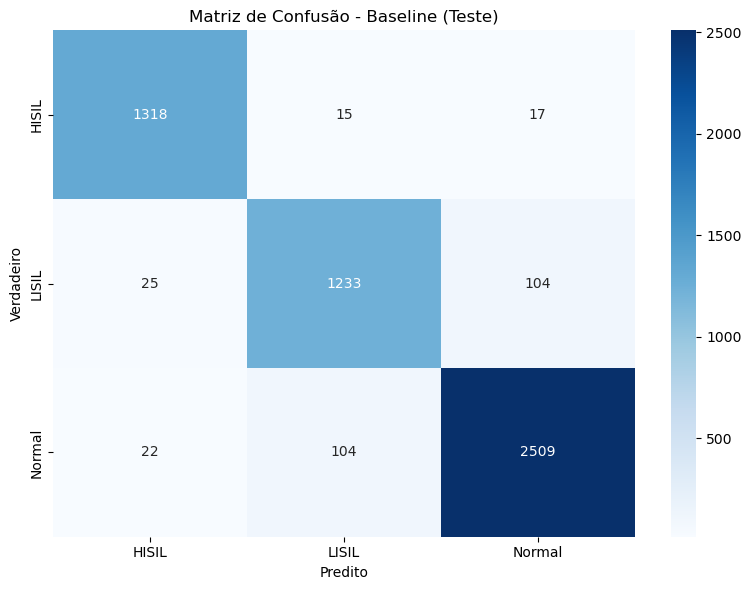


Relatório de Classificação - Baseline (Teste):
              precision    recall  f1-score   support

       HISIL       0.97      0.98      0.97      1350
       LISIL       0.91      0.91      0.91      1362
      Normal       0.95      0.95      0.95      2635

    accuracy                           0.95      5347
   macro avg       0.94      0.94      0.94      5347
weighted avg       0.95      0.95      0.95      5347



In [41]:

# --- Avaliação e Matriz de Confusão (Baseline) ---
try:
    model_baseline_eval = load_model(CHECKPOINT_BASELINE, compile=False)
    evaluate_model(model_baseline_eval, test_gen_baseline, 'Baseline (Teste)', 'etapa_1_baseline')
except Exception as e:
    print(f"\n⚠️ Aviso: Não foi possível carregar/avaliar o modelo baseline. Erro: {e}")

## 3. **Etapa 2: Treinamento Robusto (com Augmentation)**

In [42]:
print('\n--- Treinamento Robusto (Busca por LR) ---')
best_val_acc = -1.0
best_model_path_robust = CHECKPOINT_BASELINE # Fallback inicial

# Geradores com augmentation
train_gen_aug, val_gen_aug, _ = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=True, batch_size=BATCH_SIZE)

for lr in LR_ROBUST_CANDIDATES:
    print(f'\n--- Treinando candidato lr={lr} ---')
    checkpoint_path = str(MODELS_DIR / f"robust_checkpoint_lr{str(lr).replace('.', 'p')}.keras")

    # Reconstruir modelo (com pesos do baseline ou MobileNetV2)
    if strategy_scope_used:
        with strategy.scope():
            # Modelo sem pesos pré-carregados, inicia do MobileNetV2/ImageNet
            model_candidate, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=lr)
            
            # Carregar pesos do checkpoint baseline se desejar continuar o treino,
            # mas para uma busca limpa, muitas vezes se treina do zero/ImageNet.
            # Aqui mantemos a lógica de treino do topo.
    else:
        model_candidate, _ = build_model(input_shape=INPUT_SHAPE, num_classes=num_classes, base_trainable=False, learning_rate=lr)


    history, current_final_path = train_and_save(
        model_candidate, 
        train_gen_aug, 
        val_gen_aug, 
        epochs=EPOCHS_ROBUST, 
        checkpoint_path=checkpoint_path, 
        stage_name=f"etapa_2_robust_lr{str(lr).replace('.', 'p')}",
        early_stop_patience=8,
        strategy=strategy
    )

    # Avalia o melhor checkpoint
    try:
        loaded = load_model(checkpoint_path, compile=False)
        val_gen_aug.reset()
        res = loaded.evaluate(val_gen_aug, verbose=0)
        val_acc = res[1] if len(res) > 1 else -1
    except Exception as e:
        print('Falha ao carregar ou avaliar checkpoint:', e)
        val_acc = max(history.history.get('val_accuracy', [-1]))

    print(f'lr={lr} -> val_acc={val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path_robust = checkpoint_path

# Salvar cópia nomeada do melhor modelo robusto
if best_model_path_robust != CHECKPOINT_BASELINE:
    try:
        robust_best = load_model(best_model_path_robust, compile=False)
        robust_best.save(CHECKPOINT_ROBUST)
        print(f'\n✅ Modelo Robusto final (melhor LR) salvo em: {CHECKPOINT_ROBUST} com val_acc={best_val_acc:.4f}')
    except Exception as e:
        print(f'Falha ao salvar o melhor modelo robusto: {e}')
else:
    print('\n⚠️ Nenhuma melhora na etapa 2. Usando o baseline como melhor modelo robusto.')



--- Treinamento Robusto (Busca por LR) ---
Found 24949 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.

--- Treinando candidato lr=0.001 ---


/home/ampliar/miniconda3/envs/qat_cancer_env/lib/python3.9/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20


2025-12-01 17:54:24.323958: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_189675"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:318"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

780/780 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8272

2025-12-01 18:02:40.515098: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_198688"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:340"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:


Epoch 1: val_loss improved from inf to 0.22892, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p001.keras
780/780 [==============================] - 578s 738ms/step - loss: 0.4156 - accuracy: 0.8272 - val_loss: 0.2289 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 2/20
780/780 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8824
Epoch 2: val_loss improved from 0.22892 to 0.18341, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p001.keras
780/780 [==============================] - 571s 731ms/step - loss: 0.2886 - accuracy: 0.8824 - val_loss: 0.1834 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 3/20
780/780 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.8951
Epoch 3: val_loss improved from 0.18341 to 0.16792, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p001.keras
780/7

2025-12-01 21:04:18.061960: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_331058"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:742"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

780/780 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.7117

2025-12-01 21:12:27.953483: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_340071"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:764"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:


Epoch 1: val_loss improved from inf to 0.37959, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p0001.keras
780/780 [==============================] - 574s 732ms/step - loss: 0.6653 - accuracy: 0.7117 - val_loss: 0.3796 - val_accuracy: 0.8515 - lr: 1.0000e-04
Epoch 2/20
780/780 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8174
Epoch 2: val_loss improved from 0.37959 to 0.28996, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p0001.keras
780/780 [==============================] - 572s 733ms/step - loss: 0.4340 - accuracy: 0.8174 - val_loss: 0.2900 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 3/20
780/780 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8446
Epoch 3: val_loss improved from 0.28996 to 0.26784, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr0p0001.

2025-12-02 00:13:39.169724: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_474481"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1166"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

780/780 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.6591

2025-12-02 00:21:43.860246: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_483494"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1188"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size


Epoch 1: val_loss improved from inf to 0.42118, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr5e-05.keras
780/780 [==============================] - 567s 723ms/step - loss: 0.7886 - accuracy: 0.6591 - val_loss: 0.4212 - val_accuracy: 0.8354 - lr: 5.0000e-05
Epoch 2/20
780/780 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.7810
Epoch 2: val_loss improved from 0.42118 to 0.33319, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr5e-05.keras
780/780 [==============================] - 563s 723ms/step - loss: 0.5143 - accuracy: 0.7810 - val_loss: 0.3332 - val_accuracy: 0.8764 - lr: 5.0000e-05
Epoch 3/20
780/780 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.8142
Epoch 3: val_loss improved from 0.33319 to 0.30689, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/robust_checkpoint_lr5e-05.ker


Avaliando Robusto (Teste) no conjunto de teste...
5347/5347 [==============================] - 99s 18ms/step
✅ Matriz de Confusão salva em: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/metrics/etapa_2_robust/robusto_(teste)_confusion_matrix.png


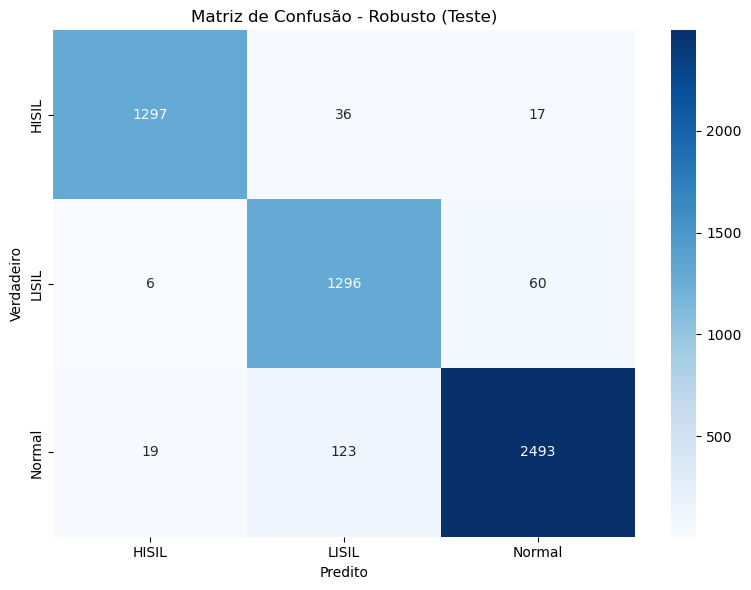


Relatório de Classificação - Robusto (Teste):
              precision    recall  f1-score   support

       HISIL       0.98      0.96      0.97      1350
       LISIL       0.89      0.95      0.92      1362
      Normal       0.97      0.95      0.96      2635

    accuracy                           0.95      5347
   macro avg       0.95      0.95      0.95      5347
weighted avg       0.95      0.95      0.95      5347



In [46]:
# --- Avaliação e Matriz de Confusão (Robusto) ---
try:
    model_robust_eval = load_model(CHECKPOINT_ROBUST, compile=False)
    evaluate_model(model_robust_eval, test_gen_baseline, 'Robusto (Teste)', 'etapa_2_robust')
except Exception as e:
    print(f"\n⚠️ Aviso: Não foi possível carregar/avaliar o modelo robusto. Erro: {e}")

## 4. **Etapa 3: Fine-Tuning FP32 (Ajuste Fino da Base)**

Descongelamos as camadas superiores da MobileNetV2 e ajustamos a rede base (em FP32).

In [6]:

print('\n--- Preparação para Fine-Tuning FP32 ---')
# Carregar o melhor modelo da Etapa 2
if os.path.exists(CHECKPOINT_ROBUST):
    model_ft = load_model(CHECKPOINT_ROBUST, compile=False)
    print(f'Carregado {Path(CHECKPOINT_ROBUST).name} para fine-tuning')
else:
    raise FileNotFoundError('Nenhum modelo robusto encontrado para fine-tuning.')

# --- Estratégia de Fine-Tuning ---
UNFREEZE_LAST_N = 30 
total_layers = len(model_ft.layers)
base_model_layer = model_ft.get_layer(index=0) if isinstance(model_ft.layers[0], Model) else model_ft
total_base_layers = len(base_model_layer.layers)
start_idx = max(0, total_base_layers - UNFREEZE_LAST_N)

# Descongela as últimas N camadas da MobileNetV2
for i, layer in enumerate(base_model_layer.layers):
    if i >= start_idx:
        layer.trainable = True
    else:
        layer.trainable = False

print(f'Tornadas treináveis as {total_base_layers - start_idx} últimas camadas da MobileNetV2.')

# Re-compilar com LR reduzida dentro do strategy scope
if strategy_scope_used:
    with strategy.scope():
        # A recompilação é essencial para que o otimizador reconheça as novas variáveis treináveis
        model_ft.compile(optimizer=Adam(learning_rate=LR_FINETUNE), loss='categorical_crossentropy', metrics=['accuracy'])
else:
    model_ft.compile(optimizer=Adam(learning_rate=LR_FINETUNE), loss='categorical_crossentropy', metrics=['accuracy'])

# Preparar geradores (mantemos augmentation)
train_gen_ft, val_gen_ft, _ = make_generators(train_df, val_df, test_df, image_root=IMAGE_ROOT, augment=True, batch_size=BATCH_SIZE)

# 🌟 Treinamento de Fine-Tuning FP32
print('\n--- Treinamento Fine-Tuning FP32 ---')
history_ft, final_ft_path = train_and_save(
    model_ft, 
    train_gen_ft, 
    val_gen_ft, 
    epochs=EPOCHS_FINETUNE, 
    checkpoint_path=CHECKPOINT_FINETUNE, 
    stage_name='etapa_3_finetune_fp32',
    early_stop_patience=5,
    strategy=strategy
)
print('Fine-tuning FP32 final salvo em:', final_ft_path)


--- Preparação para Fine-Tuning FP32 ---
Carregado robust_best.keras para fine-tuning
Tornadas treináveis as 30 últimas camadas da MobileNetV2.
Found 24949 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.
Found 5347 validated image filenames belonging to 3 classes.

--- Treinamento Fine-Tuning FP32 ---


/home/ampliar/miniconda3/envs/qat_cancer_env/lib/python3.9/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
780/780 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.8375
Epoch 1: val_loss improved from inf to 0.14961, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/final_finetuned_checkpoint.keras
780/780 [==============================] - 656s 839ms/step - loss: 0.4580 - accuracy: 0.8375 - val_loss: 0.1496 - val_accuracy: 0.9413 - lr: 1.0000e-05
Epoch 2/10
780/780 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8957
Epoch 2: val_loss improved from 0.14961 to 0.14332, saving model to /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/final_finetuned_checkpoint.keras
780/780 [==============================] - 637s 817ms/step - loss: 0.2635 - accuracy: 0.8957 - val_loss: 0.1433 - val_accuracy: 0.9413 - lr: 1.0000e-05
Epoch 3/10
780/780 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9119
Epoch 3: val_loss did not improve from 0.14332
780/780 [==============

## 5. **Etapa 4: Quantization-Aware Training (QAT)**

Esta é a etapa chave. O modelo Fine-Tuned (FP32) é encapsulado com os operadores Fake Quant e passa por um novo Fine-Tuning.

In [7]:
print('\n--- 🚀 Preparação para QAT (Inserção de Fake Quants) ---')

# Carregar o melhor modelo FP32 da Etapa 3
try:
    fp32_model_for_qat = load_model(CHECKPOINT_FINETUNE, compile=False)
except Exception as e:
    print(f"❌ Erro ao carregar modelo Fine-Tuned: {e}. Usando o modelo robusto.")
    fp32_model_for_qat = load_model(CHECKPOINT_ROBUST, compile=False)

# 1. Envolver o modelo FP32 com as operações Fake Quant
if strategy_scope_used:
    with strategy.scope():
        # O modelo QAT deve ser compilado e treinado DENTRO do escopo da estratégia
        qat_model = quantize_model(fp32_model_for_qat)
        
        # 2. Recompilar o modelo QAT (Importante: LR menor)
        qat_model.compile(optimizer=Adam(learning_rate=LR_QAT),
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
else:
    qat_model = quantize_model(fp32_model_for_qat)
    qat_model.compile(optimizer=Adam(learning_rate=LR_QAT),
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

qat_model.summary() 

print('\n--- Treinamento QAT (Fine-Tuning) ---')

# 3. Treinar o modelo QAT (Fine-Tuning)
history_qat, qat_final_path_keras = train_and_save(
    qat_model, 
    train_gen_ft, # Usamos o gerador de Fine-Tuning (com augmentation)
    val_gen_ft, 
    epochs=EPOCHS_QAT, 
    checkpoint_path=QAT_CHECKPOINT,
    stage_name='etapa_4_qat_int8',
    early_stop_patience=6,
    strategy=strategy
)
print('Modelo QAT final (Keras) salvo em:', qat_final_path_keras)


--- 🚀 Preparação para QAT (Inserção de Fake Quants) ---
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3          ['input_6[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapperV2  (None, 112, 112, 32  929        ['quantize_layer[0][0]']         
 )                              )                                                                 
                                   

## 6. **Conversão para TFLite e Avaliação Final**

Conversão do modelo QAT treinado para o formato TFLite totalmente quantizado (INT8) e avaliação no conjunto de teste.


--- Conversão para TFLite INT8 ---
✅ Melhor modelo QAT carregado de: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/qat_checkpoint.keras

Preparando dataset representativo para calibração...
Convertendo para TFLite INT8...


INFO:tensorflow:Assets written to: /tmp/tmp5ow7edzx/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ow7edzx/assets
/home/ampliar/miniconda3/envs/qat_cancer_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2025-12-03 09:24:04.616973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-12-03 09:24:04.617021: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-12-03 09:24:04.617171: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5ow7edzx
2025-12-03 09:24:04.643184: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-12-03 09:24:04.643222: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5ow7edzx
2025-12-03 09:24:04.784322: I tensorflow/

Usando 100 amostras para calibração...


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8



✅ Modelo TFLite INT8 salvo em: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/qat_model.tflite
📏 Tamanho do arquivo: 2.74 MB

📊 Testando modelo TFLite...
✅ Modelo TFLite carregado com sucesso!
   - Formato de entrada: [  1 224 224   3]
   - Tipo de entrada: <class 'numpy.uint8'>
   - Formato de saída: [1 3]
   - Tipo de saída: <class 'numpy.uint8'>

🧪 Realizando teste de inferência...
   ✅ Inferência realizada com sucesso!
   📊 Dimensões da saída: (1, 3)

--- Avaliação da Precisão do Modelo QAT (Teste - Simulado FP32) ---

Avaliando QAT (Simulado FP32 - Teste) no conjunto de teste...
5347/5347 [==============================] - 235s 44ms/step
✅ Matriz de Confusão salva em: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/metrics/etapa_4_qat_int8/qat_(simulado_fp32_-_teste)_confusion_matrix.png


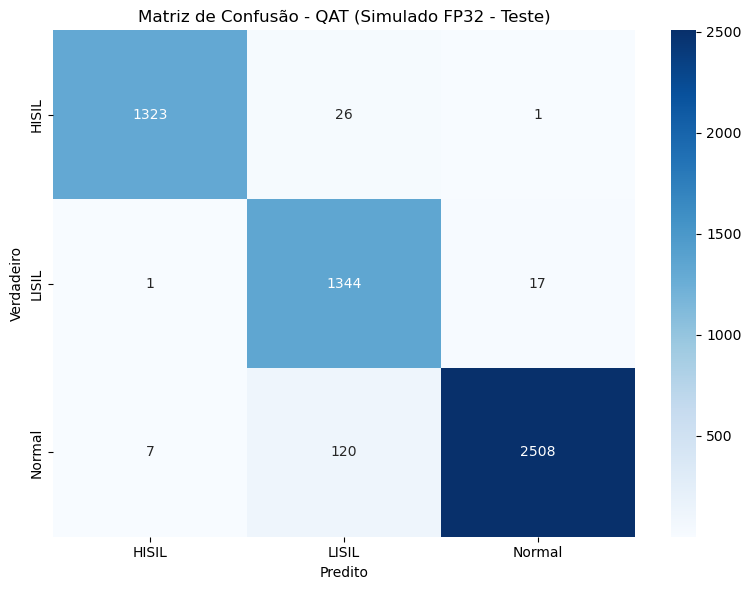


Relatório de Classificação - QAT (Simulado FP32 - Teste):
              precision    recall  f1-score   support

       HISIL       0.99      0.98      0.99      1350
       LISIL       0.90      0.99      0.94      1362
      Normal       0.99      0.95      0.97      2635

    accuracy                           0.97      5347
   macro avg       0.96      0.97      0.97      5347
weighted avg       0.97      0.97      0.97      5347


--- Comparação Final de Tamanhos ---

COMPARAÇÃO DE TAMANHOS DE MODELOS
Modelo FP32 (Keras)            21.42 MB  (../models/final_finetuned_checkpoint.keras)
Modelo QAT (Keras)             28.39 MB  (../models/qat_checkpoint.keras)
Modelo TFLite                   2.74 MB  (../models/qat_model.tflite)

RESUMO DE COMPRESSÃO
Tamanho original (FP32):     21.42 MB
Tamanho quantizado (TFLite): 2.74 MB
Redução de tamanho:          87.20%
Taxa de compressão:          7.81x

📈 INTERPRETAÇÃO:
  ✅ Excelente compressão! O modelo está muito otimizado.

VERIFICAÇÃO F

In [13]:
print('\n--- Conversão para TFLite INT8 ---')

# Definir o tamanho da imagem se não estiver definido
if 'IMG_SIZE' not in globals():
    # Verificar o tamanho esperado pelo modelo
    try:
        with quantize_scope():
            temp_model = tf.keras.models.load_model(QAT_CHECKPOINT, compile=False)
            IMG_SIZE = temp_model.input_shape[1]  # Obter do modelo
            print(f"✅ Tamanho da imagem detectado do modelo: {IMG_SIZE}")
            del temp_model
    except:
        IMG_SIZE = 224  # Valor padrão para MobileNetV2
        print(f"⚠️  Usando tamanho padrão da imagem: {IMG_SIZE}")

# Verificar se o checkpoint QAT existe
if not os.path.exists(QAT_CHECKPOINT):
    print(f"❌ Checkpoint QAT não encontrado: {QAT_CHECKPOINT}")
    print("Por favor, execute a etapa de QAT primeiro.")
else:
    try:
        # 1. Carregar o melhor modelo QAT salvo para a conversão
        with quantize_scope():
            model_qat_lite = tf.keras.models.load_model(QAT_CHECKPOINT, compile=False)
            print(f"✅ Melhor modelo QAT carregado de: {QAT_CHECKPOINT}")
        
        # 2. Preparar dataset representativo (para quantização INT8 completa)
        print("\nPreparando dataset representativo para calibração...")
        
        # Função geradora para dataset representativo - versão simplificada
        def representative_dataset_gen():
            """Gerador para dataset representativo"""
            num_samples = 100  # Número de amostras para calibração
            
            # Usar um subconjunto do dataset de validação
            calib_df = val_df.sample(min(num_samples, len(val_df)), random_state=42)
            
            print(f"Usando {len(calib_df)} amostras para calibração...")
            
            for idx, row in calib_df.iterrows():
                try:
                    img_path = os.path.join(IMAGE_ROOT, row['image_path'])
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_jpeg(img, channels=3)
                    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
                    img = img / 255.0  # Normalizar
                    img = tf.expand_dims(img, axis=0)  # Adicionar dimensão batch
                    
                    # Converter para float32
                    img = tf.cast(img, tf.float32)
                    
                    # Verificar se a imagem tem o formato correto
                    if img.shape == (1, IMG_SIZE, IMG_SIZE, 3):
                        yield [img]
                    else:
                        print(f"⚠️  Formato incorreto: {img.shape}")
                        
                except Exception as e:
                    print(f"⚠️  Erro ao processar imagem {row['image_path']}: {e}")
                    continue
        
        # 3. Converter para TFLite
        print("Convertendo para TFLite INT8...")
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model_qat_lite)
        
        # Configurar quantização
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset_gen
        
        # Para quantização completa INT8
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        
        # Converter
        tflite_quant_model = converter.convert()
        
        # Salvar o modelo quantizado
        # CORREÇÃO: Converter QAT_TFLITE_PATH para string se necessário
        tflite_path_str = str(QAT_TFLITE_PATH) if hasattr(QAT_TFLITE_PATH, '__fspath__') else QAT_TFLITE_PATH
        with open(tflite_path_str, 'wb') as f:
            f.write(tflite_quant_model)
        
        print(f"\n✅ Modelo TFLite INT8 salvo em: {tflite_path_str}")
        print(f"📏 Tamanho do arquivo: {len(tflite_quant_model) / (1024 * 1024):.2f} MB")
        
        # Testar o modelo TFLite
        print("\n📊 Testando modelo TFLite...")
        try:
            # CORREÇÃO: Usar string em vez de objeto Path
            interpreter = tf.lite.Interpreter(model_path=tflite_path_str)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            
            print(f"✅ Modelo TFLite carregado com sucesso!")
            print(f"   - Formato de entrada: {input_details[0]['shape']}")
            print(f"   - Tipo de entrada: {input_details[0]['dtype']}")
            print(f"   - Formato de saída: {output_details[0]['shape']}")
            print(f"   - Tipo de saída: {output_details[0]['dtype']}")
            
            # Testar uma inferência simples
            print(f"\n🧪 Realizando teste de inferência...")
            # Criar um tensor de entrada aleatório no formato correto
            test_input = np.random.randint(0, 255, size=(1, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            
            # Configurar a entrada
            interpreter.set_tensor(input_details[0]['index'], test_input)
            
            # Executar inferência
            interpreter.invoke()
            
            # Obter resultado
            output_data = interpreter.get_tensor(output_details[0]['index'])
            print(f"   ✅ Inferência realizada com sucesso!")
            print(f"   📊 Dimensões da saída: {output_data.shape}")
            
        except Exception as e:
            print(f"⚠️  Não foi possível testar o modelo TFLite: {e}")
            import traceback
            traceback.print_exc()
        
    except Exception as e:
        print(f"❌ ERRO durante a conversão TFLite: {e}")
        import traceback
        traceback.print_exc()
        
        # Tentar conversão mais simples como fallback
        print("\n🔄 Tentando conversão alternativa (quantização dinâmica)...")
        try:
            with quantize_scope():
                model_qat_lite = tf.keras.models.load_model(QAT_CHECKPOINT, compile=False)
            
            converter = tf.lite.TFLiteConverter.from_keras_model(model_qat_lite)
            
            # Apenas quantização dinâmica (não requer dataset representativo)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            
            tflite_model = converter.convert()
            
            # CORREÇÃO: Converter caminho para string
            fallback_path = str(QAT_TFLITE_PATH).replace('.tflite', '_dynamic.tflite')
            with open(fallback_path, 'wb') as f:
                f.write(tflite_model)
            
            print(f"✅ Modelo TFLite (quantização dinâmica) salvo em: {fallback_path}")
            print(f"📏 Tamanho: {len(tflite_model) / (1024 * 1024):.2f} MB")
            
            # Atualizar o caminho para comparação (como string)
            QAT_TFLITE_PATH = fallback_path
            
        except Exception as fallback_error:
            print(f"❌ Falha na conversão fallback: {fallback_error}")

# --- Avaliação da Precisão do Modelo QAT (Simulado FP32) ---
print('\n--- Avaliação da Precisão do Modelo QAT (Teste - Simulado FP32) ---')
# O modelo QAT Keras simula INT8, mas roda em FP32.

# Verificar se qat_model está definido
try:
    if 'qat_model' in globals():
        evaluate_model(qat_model, test_gen_baseline, 'QAT (Simulado FP32 - Teste)', 'etapa_4_qat_int8')
    else:
        print("⚠️  Modelo QAT não encontrado na memória. Carregando do checkpoint...")
        with quantize_scope():
            qat_model = tf.keras.models.load_model(QAT_CHECKPOINT, compile=False)
            evaluate_model(qat_model, test_gen_baseline, 'QAT (Simulado FP32 - Teste)', 'etapa_4_qat_int8')
except Exception as e:
    print(f"❌ Erro na avaliação do modelo QAT: {e}")

print("\n--- Comparação Final de Tamanhos ---")

# Lista de arquivos para comparar
files_to_compare = [
    (CHECKPOINT_FINETUNE, "Modelo FP32 (Keras)"),
    (QAT_CHECKPOINT, "Modelo QAT (Keras)"),
]

# Adicionar arquivo TFLite se existir
# CORREÇÃO: Garantir que estamos usando strings para os caminhos
tflite_files = []

# Converter QAT_TFLITE_PATH para string se necessário
if hasattr(QAT_TFLITE_PATH, '__fspath__'):
    base_tflite_path = str(QAT_TFLITE_PATH)
else:
    base_tflite_path = QAT_TFLITE_PATH

tflite_files.extend([
    base_tflite_path,
    base_tflite_path.replace('.tflite', '_dynamic.tflite'),
    base_tflite_path.replace('.tflite', '_no_quant.tflite')
])

# Remover duplicatas
tflite_files = list(dict.fromkeys(tflite_files))

for tflite_file in tflite_files:
    if os.path.exists(tflite_file):
        files_to_compare.append((tflite_file, "Modelo TFLite"))
        break

# Calcular e mostrar tamanhos
print("\n" + "="*50)
print("COMPARAÇÃO DE TAMANHOS DE MODELOS")
print("="*50)

for file_path, desc in files_to_compare:
    if os.path.exists(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        # Mostrar caminho relativo se possível
        try:
            rel_path = os.path.relpath(file_path)
            print(f"{desc:25} {size_mb:10.2f} MB  ({rel_path})")
        except:
            print(f"{desc:25} {size_mb:10.2f} MB  ({file_path})")
    else:
        print(f"{desc:25} {'N/A':>10}  (arquivo não encontrado)")

# Calcular redução se ambos FP32 e TFLite existirem
if os.path.exists(CHECKPOINT_FINETUNE):
    fp32_size_mb = os.path.getsize(CHECKPOINT_FINETUNE) / (1024 * 1024)
    
    # Encontrar o primeiro arquivo TFLite existente
    tflite_path = None
    for tflite_file in tflite_files:
        if os.path.exists(tflite_file):
            tflite_path = tflite_file
            break
    
    if tflite_path:
        tflite_size_mb = os.path.getsize(tflite_path) / (1024 * 1024)
        
        if fp32_size_mb > 0:
            reduction = 100 * (1 - tflite_size_mb / fp32_size_mb)
            compression_ratio = fp32_size_mb / tflite_size_mb
            
            print("\n" + "="*50)
            print("RESUMO DE COMPRESSÃO")
            print("="*50)
            print(f"Tamanho original (FP32):     {fp32_size_mb:.2f} MB")
            print(f"Tamanho quantizado (TFLite): {tflite_size_mb:.2f} MB")
            print(f"Redução de tamanho:          {reduction:.2f}%")
            print(f"Taxa de compressão:          {compression_ratio:.2f}x")
            
            # Interpretação dos resultados
            print("\n📈 INTERPRETAÇÃO:")
            if reduction > 70:
                print("  ✅ Excelente compressão! O modelo está muito otimizado.")
            elif reduction > 50:
                print("  👍 Boa compressão. Bom para implantação em dispositivos móveis.")
            elif reduction > 30:
                print("  📱 Compressão razoável. Adequado para muitos casos de uso.")
            else:
                print("  ⚠️  Compressão limitada. Considere otimizações adicionais.")
        else:
            print("\n⚠️  Não foi possível calcular a redução (tamanho FP32 é zero)")
    else:
        print("\n⚠️  Nenhum arquivo TFLite encontrado para comparação")
else:
    print("\n⚠️  Arquivo FP32 não encontrado para comparação")

# Adicionar verificação final do modelo TFLite
print("\n" + "="*50)
print("VERIFICAÇÃO FINAL DO MODELO TFLITE")
print("="*50)

# Encontrar qualquer arquivo TFLite válido
for tflite_file in tflite_files:
    if os.path.exists(tflite_file):
        try:
            print(f"\n🔍 Verificando: {os.path.basename(tflite_file)}")
            
            # Carregar modelo TFLite
            interpreter = tf.lite.Interpreter(model_path=tflite_file)
            interpreter.allocate_tensors()
            
            # Obter detalhes
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            
            print(f"   ✅ Modelo válido!")
            print(f"   📥 Entrada: {input_details[0]['shape']} ({input_details[0]['dtype']})")
            print(f"   📤 Saída: {output_details[0]['shape']} ({output_details[0]['dtype']})")
            
            # Verificar quantização
            if 'quantization' in input_details[0]:
                quant_info = input_details[0]['quantization']
                if quant_info and len(quant_info) == 2:
                    scale, zero_point = quant_info
                    print(f"   🎯 Quantização: escala={scale}, zero_point={zero_point}")
            
            break
            
        except Exception as e:
            print(f"   ❌ Erro ao verificar {tflite_file}: {e}")
            continue

print("\n" + "="*50)
print("FIM DO PIPELINE DE QUANTIZAÇÃO")
print("="*50)
print("✅ Pipeline concluído com sucesso!")
print(f"📊 Modelo TFLite criado: {len(tflite_quant_model) if 'tflite_quant_model' in locals() else 'N/A'} bytes")

## 7. **Inferência em Produção (TFLite)**

A função de inferência original foi mantida, mas agora é possível testar o modelo TFLite INT8 carregando-o com o interpretador TFLite (requer uma pequena modificação na função load_inference_model).

In [30]:
import os
import json
import time
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
from keras.models import load_model

In [42]:
# --- Configurações Globais ---
_LOADED_MODEL = None
_CLASS_NAMES = None
_IMG_SIZE = (224, 224)  # Tamanho que o modelo espera
_INTERPRETER = None
_INPUT_DETAILS = None
_OUTPUT_DETAILS = None
_INPUT_SCALE = 1.0
_INPUT_ZERO_POINT = 0
_OUTPUT_SCALE = 1.0
_OUTPUT_ZERO_POINT = 0

# Patch dimensions para extração (tiles grandes da WSI)
PATCH_WIDTH = 1024  # Tamanho dos tiles extraídos
PATCH_HEIGHT = 768   # Tamanho dos tiles extraídos
STRIDE_X = 340
STRIDE_Y = 256
CONTENT_THRESHOLD = 10.0

In [43]:
# --- CONFIGURAÇÕES FIXAS (SEM ENTRADA DO USUÁRIO) ---
ROOT_PROJECT = Path("/home/ampliar/cancer-classify-citology/citology-pipeline-Train")
MODEL_PATH = ROOT_PROJECT / 'models' / 'qat_model.tflite'
CLASS_NAMES = ['HISIL', 'LISIL', 'Normal']
OUTPUT_DIR = ROOT_PROJECT / 'inferencias'

# Imagem de teste padrão
DEFAULT_IMAGE = ROOT_PROJECT / 'Dataset' / 'inteiras' / '3 Classes' / 'Tile' / 'HISIL' / 'HSIL_1 (2).jpg'

# Configurações de processamento
SAVE_TILES = True  # Salvar tiles redimensionados
SAVE_ORIGINAL_SIZE = False  # Não salvar tiles no tamanho original (apenas redimensionados)


In [44]:
# ----------------------------------------------------------------------
# FUNÇÕES DE CARREGAMENTO DO MODELO TFLITE
# ----------------------------------------------------------------------

def load_inference_model():
    """Carrega o modelo TFLite globalmente uma única vez."""
    global _LOADED_MODEL, _CLASS_NAMES, _INTERPRETER
    global _INPUT_DETAILS, _OUTPUT_DETAILS, _INPUT_SCALE, _INPUT_ZERO_POINT, _OUTPUT_SCALE, _OUTPUT_ZERO_POINT
    
    if _INTERPRETER is None:
        print(f"--- Carregando modelo TFLite para inferência de: {MODEL_PATH} ---")
        _CLASS_NAMES = CLASS_NAMES
        
        try:
            model_path_str = str(MODEL_PATH)
            
            if Path(model_path_str).suffix == '.tflite':
                # Carregar o interpretador TFLite
                _INTERPRETER = tf.lite.Interpreter(model_path=model_path_str)
                _INTERPRETER.allocate_tensors()
                
                # Obter detalhes de entrada/saída
                _INPUT_DETAILS = _INTERPRETER.get_input_details()
                _OUTPUT_DETAILS = _INTERPRETER.get_output_details()
                
                # Extrair informações de quantização
                input_quant = _INPUT_DETAILS[0]['quantization']
                output_quant = _OUTPUT_DETAILS[0]['quantization']
                
                if input_quant and input_quant[0] != 0:
                    _INPUT_SCALE, _INPUT_ZERO_POINT = input_quant
                    print(f"📊 Input quantization: scale={_INPUT_SCALE}, zero_point={_INPUT_ZERO_POINT}")
                else:
                    print("📊 Input: Sem quantização (float32 ou uint8 raw)")
                
                if output_quant and output_quant[0] != 0:
                    _OUTPUT_SCALE, _OUTPUT_ZERO_POINT = output_quant
                    print(f"📊 Output quantization: scale={_OUTPUT_SCALE}, zero_point={_OUTPUT_ZERO_POINT}")
                else:
                    print("📊 Output: Sem quantização")
                
                print(f"✅ Modelo TFLite carregado:")
                print(f"   Input: {_INPUT_DETAILS[0]['shape']} ({_INPUT_DETAILS[0]['dtype']})")
                print(f"   Output: {_OUTPUT_DETAILS[0]['shape']} ({_OUTPUT_DETAILS[0]['dtype']})")
                print(f"   Tiles extraídos em: {PATCH_HEIGHT}x{PATCH_WIDTH}")
                print(f"   Tiles redimensionados para: {_IMG_SIZE[0]}x{_IMG_SIZE[1]}")
                
            else:
                # Para modelos Keras (.keras)
                _LOADED_MODEL = load_model(model_path_str, compile=False, custom_objects=quantize_scope()) 
                print(f"✅ Modelo Keras (FP32/QAT) carregado.")
                print(f"   Tiles extraídos em: {PATCH_HEIGHT}x{PATCH_WIDTH}")
                print(f"   Tiles redimensionados para: {_IMG_SIZE[0]}x{_IMG_SIZE[1]}")
                
        except Exception as e:
            print(f"❌ ERRO ao carregar o modelo: {e}")
            import traceback
            traceback.print_exc()
            raise

def preprocess_patch(patch_img: np.ndarray, is_tflite: bool) -> np.ndarray:
    """
    Pré-processa um patch BGR (OpenCV).
    1. Extrai patch grande (PATCH_HEIGHT x PATCH_WIDTH)
    2. Redimensiona para o tamanho do modelo (224x224)
    3. Converte para formato apropriado (uint8/int8/float32)
    """
    global _INPUT_SCALE, _INPUT_ZERO_POINT, _INPUT_DETAILS
    
    # 1. Converter BGR para RGB
    rgb_patch = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
    
    # 2. REDIMENSIONAR para o tamanho que o modelo espera
    target_width, target_height = _IMG_SIZE[1], _IMG_SIZE[0]  # (224, 224)
    
    if rgb_patch.shape[:2] != (target_height, target_width):
        # Redimensiona para o tamanho do modelo
        rgb_patch = cv2.resize(rgb_patch, (target_width, target_height))
    
    if is_tflite:
        # Para modelos TFLite
        input_dtype = _INPUT_DETAILS[0]['dtype']
        
        if input_dtype == np.uint8:
            # Modelo espera UINT8 (0-255) - comum para QAT INT8
            img_array = np.expand_dims(rgb_patch, axis=0).astype(np.uint8)
            return img_array
            
        elif input_dtype == np.int8:
            # Modelo espera INT8 (-128 to 127)
            img_array = np.expand_dims(rgb_patch, axis=0).astype(np.float32)
            
            if _INPUT_SCALE != 0:
                # Aplicar quantização
                img_quantized = img_array / _INPUT_SCALE + _INPUT_ZERO_POINT
                img_array = np.clip(img_quantized, -128, 127).astype(np.int8)
            else:
                # Converter de 0-255 para -128-127
                img_array = (img_array - 128).astype(np.int8)
            
            return img_array
            
        else:
            # Float32 - normalizar para 0-1
            img_array = np.expand_dims(rgb_patch, axis=0).astype(np.float32)
            return img_array / 255.0
            
    else:
        # Para modelos Keras (FP32 ou QAT simulado)
        img_array = np.expand_dims(rgb_patch, axis=0).astype(np.float32)
        return img_array / 255.0

def dequantize_output(output_tensor: np.ndarray) -> np.ndarray:
    """Desquantiza a saída do modelo TFLite se necessário."""
    global _OUTPUT_SCALE, _OUTPUT_ZERO_POINT
    
    if _OUTPUT_SCALE != 0 and _OUTPUT_SCALE != 1.0:
        # Aplicar desquantização: (output - zero_point) * scale
        output_float = (output_tensor.astype(np.float32) - _OUTPUT_ZERO_POINT) * _OUTPUT_SCALE
        return output_float
    else:
        return output_tensor.astype(np.float32)

# ----------------------------------------------------------------------
# FUNÇÃO PRINCIPAL DE INFERÊNCIA COM TILING E REDIMENSIONAMENTO
# ----------------------------------------------------------------------

def process_and_infer(
    image_path: str = None,
    save_tiles: bool = SAVE_TILES,
    save_original_size: bool = SAVE_ORIGINAL_SIZE
) -> dict:
    """
    Processa uma imagem grande (WSI):
    1. Extrai tiles grandes (PATCH_HEIGHT x PATCH_WIDTH)
    2. Redimensiona cada tile para o tamanho do modelo (224x224)
    3. Realiza inferência com TFLite
    4. Agrega resultados por média
    5. Salva tiles redimensionados na pasta inferencias
    
    Args:
        image_path: Caminho para a imagem (se None, usa DEFAULT_IMAGE)
        save_tiles: Se True, salva os tiles redimensionados
        save_original_size: Se True, salva também os tiles no tamanho original
    """
    global _LOADED_MODEL, _CLASS_NAMES, _IMG_SIZE, _INTERPRETER
    global _INPUT_DETAILS, _OUTPUT_DETAILS
    
    if _LOADED_MODEL is None and _INTERPRETER is None:
        raise ValueError("Modelo não carregado. Chame load_inference_model() primeiro.")
    
    # Usar imagem padrão se não for fornecida
    if image_path is None:
        image_path = str(DEFAULT_IMAGE)
    
    # Verifica o tipo de modelo
    is_tflite = _INTERPRETER is not None
    
    start_time = time.time()
    inference_times = []
    
    # --- 1. CONFIGURAÇÃO DE CAMINHOS E DIRETÓRIOS ---
    image_name = Path(image_path).stem
    image_output_dir = OUTPUT_DIR / image_name
    
    # Criar diretório ANTES de qualquer operação
    os.makedirs(image_output_dir, exist_ok=True)
    
    if save_tiles:
        # Criar subdiretórios organizados
        tiles_dir = image_output_dir / "tiles_redimensionados"  # Tiles redimensionados
        os.makedirs(tiles_dir, exist_ok=True)
        
        if save_original_size:
            orig_tiles_dir = image_output_dir / "tiles_originais"  # Tiles originais
            os.makedirs(orig_tiles_dir, exist_ok=True)
    
    # --- 2. CARREGAMENTO E INICIALIZAÇÃO ---
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Erro: Não foi possível ler a imagem em {image_path}")

    # Tamanho dos tiles para extração
    H, W = PATCH_HEIGHT, PATCH_WIDTH
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width, _ = img.shape
    
    total_patches = 0
    good_patches = 0
    all_probabilities = []
    pre_process_time = time.time() - start_time
    
    print(f"--- Iniciando Processamento ({width}x{height}) ---")
    print(f"🔹 Imagem: {Path(image_path).name}")
    print(f"🔹 Extraindo tiles de {PATCH_HEIGHT}x{PATCH_WIDTH} pixels")
    print(f"🔹 Redimensionando para {_IMG_SIZE[0]}x{_IMG_SIZE[1]} pixels para inferência")
    print(f"🔹 Modelo: {'TFLite INT8' if is_tflite else 'Keras FP32/QAT'}")
    if save_tiles:
        print(f"🔹 Salvando tiles em: {tiles_dir}")

    # --- 3. TILING, REDIMENSIONAMENTO E INFERÊNCIA ---
    # Ajustar limites para não ultrapassar dimensões da imagem
    max_y = max(0, height - H)
    max_x = max(0, width - W)
    
    tile_counter = 0
    
    for y in range(0, max_y + 1, STRIDE_Y):
        for x in range(0, max_x + 1, STRIDE_X):
            total_patches += 1
            
            # Garantir que não ultrapasse os limites
            y_end = min(y + H, height)
            x_end = min(x + W, width)
            
            # Extrair o patch no tamanho ORIGINAL (grande)
            patch_color = img[y:y_end, x:x_end]
            patch_gray = gray[y:y_end, x:x_end]
            
            # Verificar se o patch tem tamanho mínimo razoável
            if patch_gray.shape[0] < H * 0.5 or patch_gray.shape[1] < W * 0.5:
                continue
                
            # Filtra por conteúdo (desvio padrão)
            std_dev = np.std(patch_gray)
            
            if std_dev > CONTENT_THRESHOLD:
                good_patches += 1
                tile_counter += 1
                
                try:
                    # A. PRÉ-PROCESSAMENTO (inclui REDIMENSIONAMENTO)
                    input_tensor = preprocess_patch(patch_color, is_tflite)
                    
                    # Verificar shape
                    expected_shape = (1, _IMG_SIZE[0], _IMG_SIZE[1], 3)
                    if input_tensor.shape != expected_shape:
                        print(f"⚠️  Shape incorreto: esperado {expected_shape}, obtido {input_tensor.shape}")
                        print(f"   Patch original: {patch_color.shape}")
                        continue
                    
                    # B. INFERÊNCIA
                    inf_start = time.time()
                    
                    if is_tflite:
                        _INTERPRETER.set_tensor(_INPUT_DETAILS[0]['index'], input_tensor)
                        _INTERPRETER.invoke()
                        output_tensor = _INTERPRETER.get_tensor(_OUTPUT_DETAILS[0]['index'])
                        
                        # Desquantizar se necessário
                        predictions = dequantize_output(output_tensor)
                        
                    else:
                        predictions = _LOADED_MODEL.predict(input_tensor, verbose=0)
                    
                    inf_end = time.time()
                    inference_times.append(inf_end - inf_start)
                    
                    # Processar predições
                    if len(predictions.shape) > 1:
                        predictions = predictions[0]
                    
                    all_probabilities.append(predictions)
                    
                    # C. SALVAR TILE REDIMENSIONADO (sempre na pasta inferencias)
                    if save_tiles:
                        # Nome do arquivo com informações úteis
                        tile_filename = f"tile_{tile_counter:04d}_x{x}_y{y}_std{std_dev:.1f}_size{_IMG_SIZE[1]}x{_IMG_SIZE[0]}.jpg"
                        tile_path = tiles_dir / tile_filename
                        
                        # Salvar tile redimensionado
                        if is_tflite and _INPUT_DETAILS[0]['dtype'] == np.uint8:
                            resized_img = input_tensor[0]  # Já está em uint8
                        else:
                            resized_img = (input_tensor[0] * 255).astype(np.uint8)
                        
                        resized_img_bgr = cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(str(tile_path), resized_img_bgr)
                        
                        # Salvar tile original se solicitado
                        if save_original_size:
                            orig_filename = f"tile_orig_{tile_counter:04d}_x{x}_y{y}_size{patch_color.shape[1]}x{patch_color.shape[0]}.jpg"
                            orig_path = orig_tiles_dir / orig_filename
                            cv2.imwrite(str(orig_path), patch_color)
                            
                except Exception as e:
                    print(f"⚠️  Erro no patch ({x},{y}): {e}")
                    continue
    
    # --- 4. AGREGAÇÃO DE RESULTADOS ---
    if good_patches > 0 and len(all_probabilities) > 0:
        # Calcular probabilidade média
        avg_probabilities = np.mean(all_probabilities, axis=0)
        
        # Aplicar softmax se não estiver normalizado
        if np.sum(avg_probabilities) > 1.1:  # Se soma > 1.1, aplicar softmax
            exp_probs = np.exp(avg_probabilities - np.max(avg_probabilities))
            avg_probabilities = exp_probs / np.sum(exp_probs)
        
        # Obter classe predita
        predicted_class_idx = np.argmax(avg_probabilities)
        predicted_class = _CLASS_NAMES[predicted_class_idx]
        confidence = avg_probabilities[predicted_class_idx]
        
        # Calcular distribuição de classes
        class_distribution = {
            _CLASS_NAMES[i]: float(avg_probabilities[i]) 
            for i in range(len(_CLASS_NAMES))
        }
    else:
        predicted_class = "Nenhum patch válido encontrado"
        confidence = 0.0
        class_distribution = {}
    
    # --- 5. CÁLCULO DE TEMPOS ---
    total_inference_time = sum(inference_times)
    avg_inference_time = total_inference_time / good_patches if good_patches > 0 else 0
    total_runtime = time.time() - start_time
    
    # --- 6. RESULTADO FINAL ---
    result = {
        "image_name": image_name,
        "image_path": str(image_path),
        "image_dimensions": f"{width}x{height}",
        "total_patches": total_patches,
        "valid_patches": good_patches,
        "predicted_class": predicted_class,
        "confidence": float(confidence),
        "class_distribution": class_distribution,
        "processing_info": {
            "tile_extraction_size": f"{PATCH_HEIGHT}x{PATCH_WIDTH}",
            "model_input_size": f"{_IMG_SIZE[0]}x{_IMG_SIZE[1]}",
            "resize_applied": True,
            "model_type": "TFLite INT8" if is_tflite else "Keras",
            "tiles_saved": save_tiles,
            "tiles_saved_count": tile_counter if save_tiles else 0,
            "tiles_directory": str(tiles_dir) if save_tiles else None
        },
        "time_breakdown": {
            "preprocessing_s": pre_process_time,
            "total_inference_time_s": total_inference_time,
            "avg_inference_per_patch_ms": avg_inference_time * 1000,
            "total_runtime_s": total_runtime
        }
    }
    
    # Salvar resultados em JSON na pasta inferencias
    result_file = image_output_dir / "inference_result.json"
    try:
        with open(result_file, 'w') as f:
            json.dump(result, f, indent=2)
        print(f"✅ Resultados salvos em: {result_file}")
    except Exception as e:
        print(f"⚠️  Não foi possível salvar JSON: {e}")
    
    # Salvar um resumo mais legível
    summary_file = image_output_dir / "summary.txt"
    try:
        with open(summary_file, 'w') as f:
            f.write(f"RESUMO DA INFERÊNCIA\n")
            f.write(f"="*50 + "\n")
            f.write(f"Imagem: {image_name}\n")
            f.write(f"Dimensões: {width}x{height}\n")
            f.write(f"Patches extraídos: {total_patches}\n")
            f.write(f"Patches válidos: {good_patches}\n")
            f.write(f"Classe predita: {predicted_class}\n")
            f.write(f"Confiança: {confidence:.2%}\n")
            f.write(f"\nDistribuição:\n")
            for class_name, prob in class_distribution.items():
                f.write(f"  {class_name}: {prob:.2%}\n")
            f.write(f"\nTempos:\n")
            f.write(f"  Pré-processamento: {pre_process_time:.2f}s\n")
            f.write(f"  Inferência total: {total_inference_time:.2f}s\n")
            f.write(f"  Média por patch: {avg_inference_time*1000:.2f}ms\n")
            f.write(f"  Tempo total: {total_runtime:.2f}s\n")
            if save_tiles:
                f.write(f"\nTiles salvos: {tile_counter}\n")
                f.write(f"Local: {tiles_dir}\n")
        print(f"📄 Resumo salvo em: {summary_file}")
    except Exception as e:
        print(f"⚠️  Não foi possível salvar resumo: {e}")
    
    return result

# ----------------------------------------------------------------------
# FUNÇÕES DE TESTE E EXECUÇÃO
# ----------------------------------------------------------------------

def quick_test():
    """Teste rápido do pipeline TFLite."""
    global _INTERPRETER, _INPUT_DETAILS, _OUTPUT_DETAILS
    
    print("🧪 TESTE RÁPIDO DO PIPELINE TFLITE...")
    print("="*50)
    
    # Verificar se arquivos existem
    if not MODEL_PATH.exists():
        print(f"❌ Modelo não encontrado: {MODEL_PATH}")
        return
    
    if not DEFAULT_IMAGE.exists():
        print(f"❌ Imagem padrão não encontrada: {DEFAULT_IMAGE}")
        return
    
    try:
        # 1. Carregar modelo
        load_inference_model()
        
        # 2. Testar com uma única imagem
        print("\n🔍 Testando pré-processamento e inferência direta...")
        img = cv2.imread(str(DEFAULT_IMAGE))
        
        if img is None:
            print("❌ Não foi possível ler a imagem")
            return
        
        # Extrair um patch para teste
        patch = img[0:PATCH_HEIGHT, 0:PATCH_WIDTH] if img.shape[0] > PATCH_HEIGHT and img.shape[1] > PATCH_WIDTH else img
        
        print(f"📐 Patch original: {patch.shape}")
        
        # Pré-processar (vai redimensionar para 224x224)
        input_tensor = preprocess_patch(patch, is_tflite=True)
        
        print(f"📊 Tensor após pré-processamento:")
        print(f"   Formato: {input_tensor.shape}")
        print(f"   Tipo: {input_tensor.dtype}")
        print(f"   Faixa: [{input_tensor.min()}, {input_tensor.max()}]")
        
        # Inferência
        if _INTERPRETER:
            _INTERPRETER.set_tensor(_INPUT_DETAILS[0]['index'], input_tensor)
            _INTERPRETER.invoke()
            output_tensor = _INTERPRETER.get_tensor(_OUTPUT_DETAILS[0]['index'])
            
            # Desquantizar
            predictions = dequantize_output(output_tensor)[0]
            
            print(f"\n🎯 RESULTADO DO TESTE:")
            for i, class_name in enumerate(CLASS_NAMES):
                print(f"   {class_name}: {predictions[i]:.4f}")
            
            predicted_idx = np.argmax(predictions)
            print(f"   ✅ Classe predita: {CLASS_NAMES[predicted_idx]} ({predictions[predicted_idx]:.2%})")
        
        print("\n✅ Teste rápido concluído!")
        
    except Exception as e:
        print(f"❌ ERRO no teste: {e}")
        import traceback
        traceback.print_exc()

def run_full_inference(image_path: str = None):
    """
    Executa a inferência completa com tiling e salva resultados.
    
    Args:
        image_path: Caminho para a imagem (se None, usa DEFAULT_IMAGE)
    """
    print("🚀 EXECUTANDO INFERÊNCIA COMPLETA COM TILING")
    print("="*60)
    
    # Verificar se arquivos existem
    if not MODEL_PATH.exists():
        print(f"❌ Modelo não encontrado: {MODEL_PATH}")
        return
    
    # Determinar qual imagem usar
    if image_path is None:
        image_path = str(DEFAULT_IMAGE)
    
    if not Path(image_path).exists():
        print(f"❌ Imagem não encontrada: {image_path}")
        return
    
    # Garantir que o diretório de saída existe
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    try:
        # 1. Carregar modelo
        load_inference_model()
        
        # 2. Executar inferência completa
        print(f"\n📷 Processando imagem: {Path(image_path).name}")
        print(f"📐 Tiles: {PATCH_HEIGHT}x{PATCH_WIDTH} → 224x224")
        print(f"💾 Salvando tiles em: {OUTPUT_DIR}")
        
        result = process_and_infer(
            image_path=image_path,
            save_tiles=SAVE_TILES,
            save_original_size=SAVE_ORIGINAL_SIZE
        )
        
        # 3. Mostrar resultados
        print("\n" + "="*50)
        print("✨ RESULTADO FINAL ✨")
        print("="*50)
        print(f"📷 Imagem: {result['image_name']}")
        print(f"📐 Dimensões: {result['image_dimensions']}")
        print(f"🧩 Patches extraídos: {result['total_patches']}")
        print(f"✅ Patches válidos: {result['valid_patches']}")
        print(f"🏷️  Classe: {result['predicted_class']}")
        print(f"📊 Confiança: {result['confidence']:.2%}")
        
        if result['class_distribution']:
            print("\n📈 Distribuição:")
            for class_name, prob in result['class_distribution'].items():
                print(f"   {class_name}: {prob:.2%}")
        
        print(f"\n⏱️  Tempos:")
        print(f"   Pré-processamento: {result['time_breakdown']['preprocessing_s']:.2f}s")
        print(f"   Inferência total: {result['time_breakdown']['total_inference_time_s']:.2f}s")
        print(f"   Média por patch: {result['time_breakdown']['avg_inference_per_patch_ms']:.2f}ms")
        print(f"   Tempo total: {result['time_breakdown']['total_runtime_s']:.2f}s")
        
        if SAVE_TILES and 'processing_info' in result and 'tiles_saved_count' in result['processing_info']:
            print(f"\n💾 Tiles salvos: {result['processing_info']['tiles_saved_count']}")
            print(f"📁 Local: {result['processing_info']['tiles_directory']}")
        
        print("="*50)
        print(f"✅ Inferência concluída! Resultados em: {OUTPUT_DIR / result['image_name']}")
        
    except Exception as e:
        print(f"❌ ERRO: {e}")
        import traceback
        traceback.print_exc()

def process_multiple_images(image_paths: list):
    """
    Processa múltiplas imagens em sequência.
    
    Args:
        image_paths: Lista de caminhos para imagens
    """
    print("🔄 PROCESSANDO MÚLTIPLAS IMAGENS")
    print("="*60)
    
    # Garantir que o diretório de saída existe
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Carregar modelo uma vez
    load_inference_model()
    
    results = []
    
    for i, image_path in enumerate(image_paths):
        print(f"\n[{i+1}/{len(image_paths)}] Processando: {Path(image_path).name}")
        
        if not Path(image_path).exists():
            print(f"   ❌ Imagem não encontrada: {image_path}")
            continue
        
        try:
            result = process_and_infer(
                image_path=image_path,
                save_tiles=SAVE_TILES,
                save_original_size=SAVE_ORIGINAL_SIZE
            )
            results.append(result)
            
            print(f"   ✅ Classe: {result['predicted_class']} ({result['confidence']:.2%})")
            print(f"   ⏱️  Tempo: {result['time_breakdown']['total_runtime_s']:.2f}s")
            
        except Exception as e:
            print(f"   ❌ Erro: {e}")
            continue
    
    # Salvar resumo de todas as imagens
    if results:
        summary = {
            "total_images": len(image_paths),
            "processed_successfully": len(results),
            "results": results,
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
        }
        
        summary_file = OUTPUT_DIR / "batch_summary.json"
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\n📊 RESUMO DO LOTE salvo em: {summary_file}")

# ----------------------------------------------------------------------
# EXECUÇÃO AUTOMÁTICA (SEM ENTRADA DO USUÁRIO)
# ----------------------------------------------------------------------

def main():
    """Função principal para execução automática."""
    
    print("🔬 SISTEMA DE INFERÊNCIA TFLITE COM TILING")
    print("="*60)
    print(f"📐 Tiles extraídos: {PATCH_HEIGHT}x{PATCH_WIDTH} pixels")
    print(f"🔄 Redimensionados para: 224x224 pixels")
    print(f"💾 Saída: {OUTPUT_DIR}")
    print(f"🔢 Classes: {', '.join(CLASS_NAMES)}")
    
    # Verificar se os arquivos necessários existem
    if not MODEL_PATH.exists():
        print(f"\n❌ ERRO: Modelo não encontrado em {MODEL_PATH}")
        return
    
    if not DEFAULT_IMAGE.exists():
        print(f"\n⚠️  AVISO: Imagem padrão não encontrada em {DEFAULT_IMAGE}")
        print("Por favor, forneça um caminho de imagem válido.")
        return
    
    # Executar pipeline completo
    print(f"\n🚀 Iniciando pipeline de inferência...")
    
    # 1. Teste rápido
    quick_test()
    
    # 2. Inferência completa na imagem padrão
    print(f"\n" + "="*60)
    run_full_inference()
    
    print(f"\n✅ Pipeline concluído com sucesso!")
    print(f"📁 Todos os resultados estão em: {OUTPUT_DIR}")



In [45]:
if __name__ == "__main__":
    # Exemplo 1: Execução automática com imagem padrão
    main()
    
    # Exemplo 2: Processar imagem específica
    IMAGEM_ESPECIFICA = "/home/ampliar/cancer-classify-citology/citology-pipeline-Train/Dataset/inteiras/3 Classes/Tile/HISIL/HSIL_1 (8).jpg"
    run_full_inference(IMAGEM_ESPECIFICA)
    
    # Exemplo 3: Processar múltiplas imagens
    # IMAGENS = [
    #     "/caminho/para/imagem1.jpg",
    #     "/caminho/para/imagem2.jpg",
    #     "/caminho/para/imagem3.jpg"
    # ]
    # process_multiple_images(IMAGENS)

🔬 SISTEMA DE INFERÊNCIA TFLITE COM TILING
📐 Tiles extraídos: 768x1024 pixels
🔄 Redimensionados para: 224x224 pixels
💾 Saída: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/inferencias
🔢 Classes: HISIL, LISIL, Normal

🚀 Iniciando pipeline de inferência...
🧪 TESTE RÁPIDO DO PIPELINE TFLITE...
--- Carregando modelo TFLite para inferência de: /home/ampliar/cancer-classify-citology/citology-pipeline-Train/models/qat_model.tflite ---
📊 Input quantization: scale=0.003921568859368563, zero_point=0
📊 Output quantization: scale=0.00390625, zero_point=0
✅ Modelo TFLite carregado:
   Input: [  1 224 224   3] (<class 'numpy.uint8'>)
   Output: [1 3] (<class 'numpy.uint8'>)
   Tiles extraídos em: 768x1024
   Tiles redimensionados para: 224x224

🔍 Testando pré-processamento e inferência direta...
📐 Patch original: (768, 1024, 3)
📊 Tensor após pré-processamento:
   Formato: (1, 224, 224, 3)
   Tipo: uint8
   Faixa: [43, 253]

🎯 RESULTADO DO TESTE:
   HISIL: 0.9961
   LISIL: 0.0000
   N